In [ ]:
pip install transformers

     |████████████████████████████████| 2.1MB 19.5MB/s 
     |████████████████████████████████| 870kB 51.3MB/s 
     |████████████████████████████████| 3.3MB 51.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=154044040880cbf4811e4e91b60e9e7796324a2a389beaa9ebb56da9f5402247
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


Using eos_token, but it is not set yet.


===== TRAINING MODEL =====
Epoch : 0
Train Loss: 1.0983104341463399 - Train Acc: 43.13%
Valid Loss: 1.0986120710077212 - Valid Acc: 46.35%
Epoch : 1
Train Loss: 1.037109501334043 - Train Acc: 46.76%
Valid Loss: 0.9263170828190885 - Valid Acc: 57.22%
Epoch : 2
Train Loss: 0.9310304563640969 - Train Acc: 55.62%
Valid Loss: 0.8957459928915482 - Valid Acc: 58.65%
Epoch : 3
Train Loss: 0.9080265705393169 - Train Acc: 57.29%
Valid Loss: 0.8800830660864364 - Valid Acc: 60.02%
Epoch : 4
Train Loss: 0.900975476722328 - Train Acc: 57.72%
Valid Loss: 0.9365842310033103 - Valid Acc: 54.53%
Epoch : 5
Train Loss: 0.8975672885790047 - Train Acc: 58.33%
Valid Loss: 0.8831409035727035 - Valid Acc: 60.76%
Epoch : 6
Train Loss: 0.8893411276523527 - Train Acc: 58.87%
Valid Loss: 0.8552706525769345 - Valid Acc: 61.40%
Epoch : 7
Train Loss: 0.8854232908337873 - Train Acc: 58.73%
Valid Loss: 0.8715130707552267 - Valid Acc: 60.45%
Epoch : 8
Train Loss: 0.8856533175538881 - Train Acc: 58.59%
Valid Loss: 0.8506

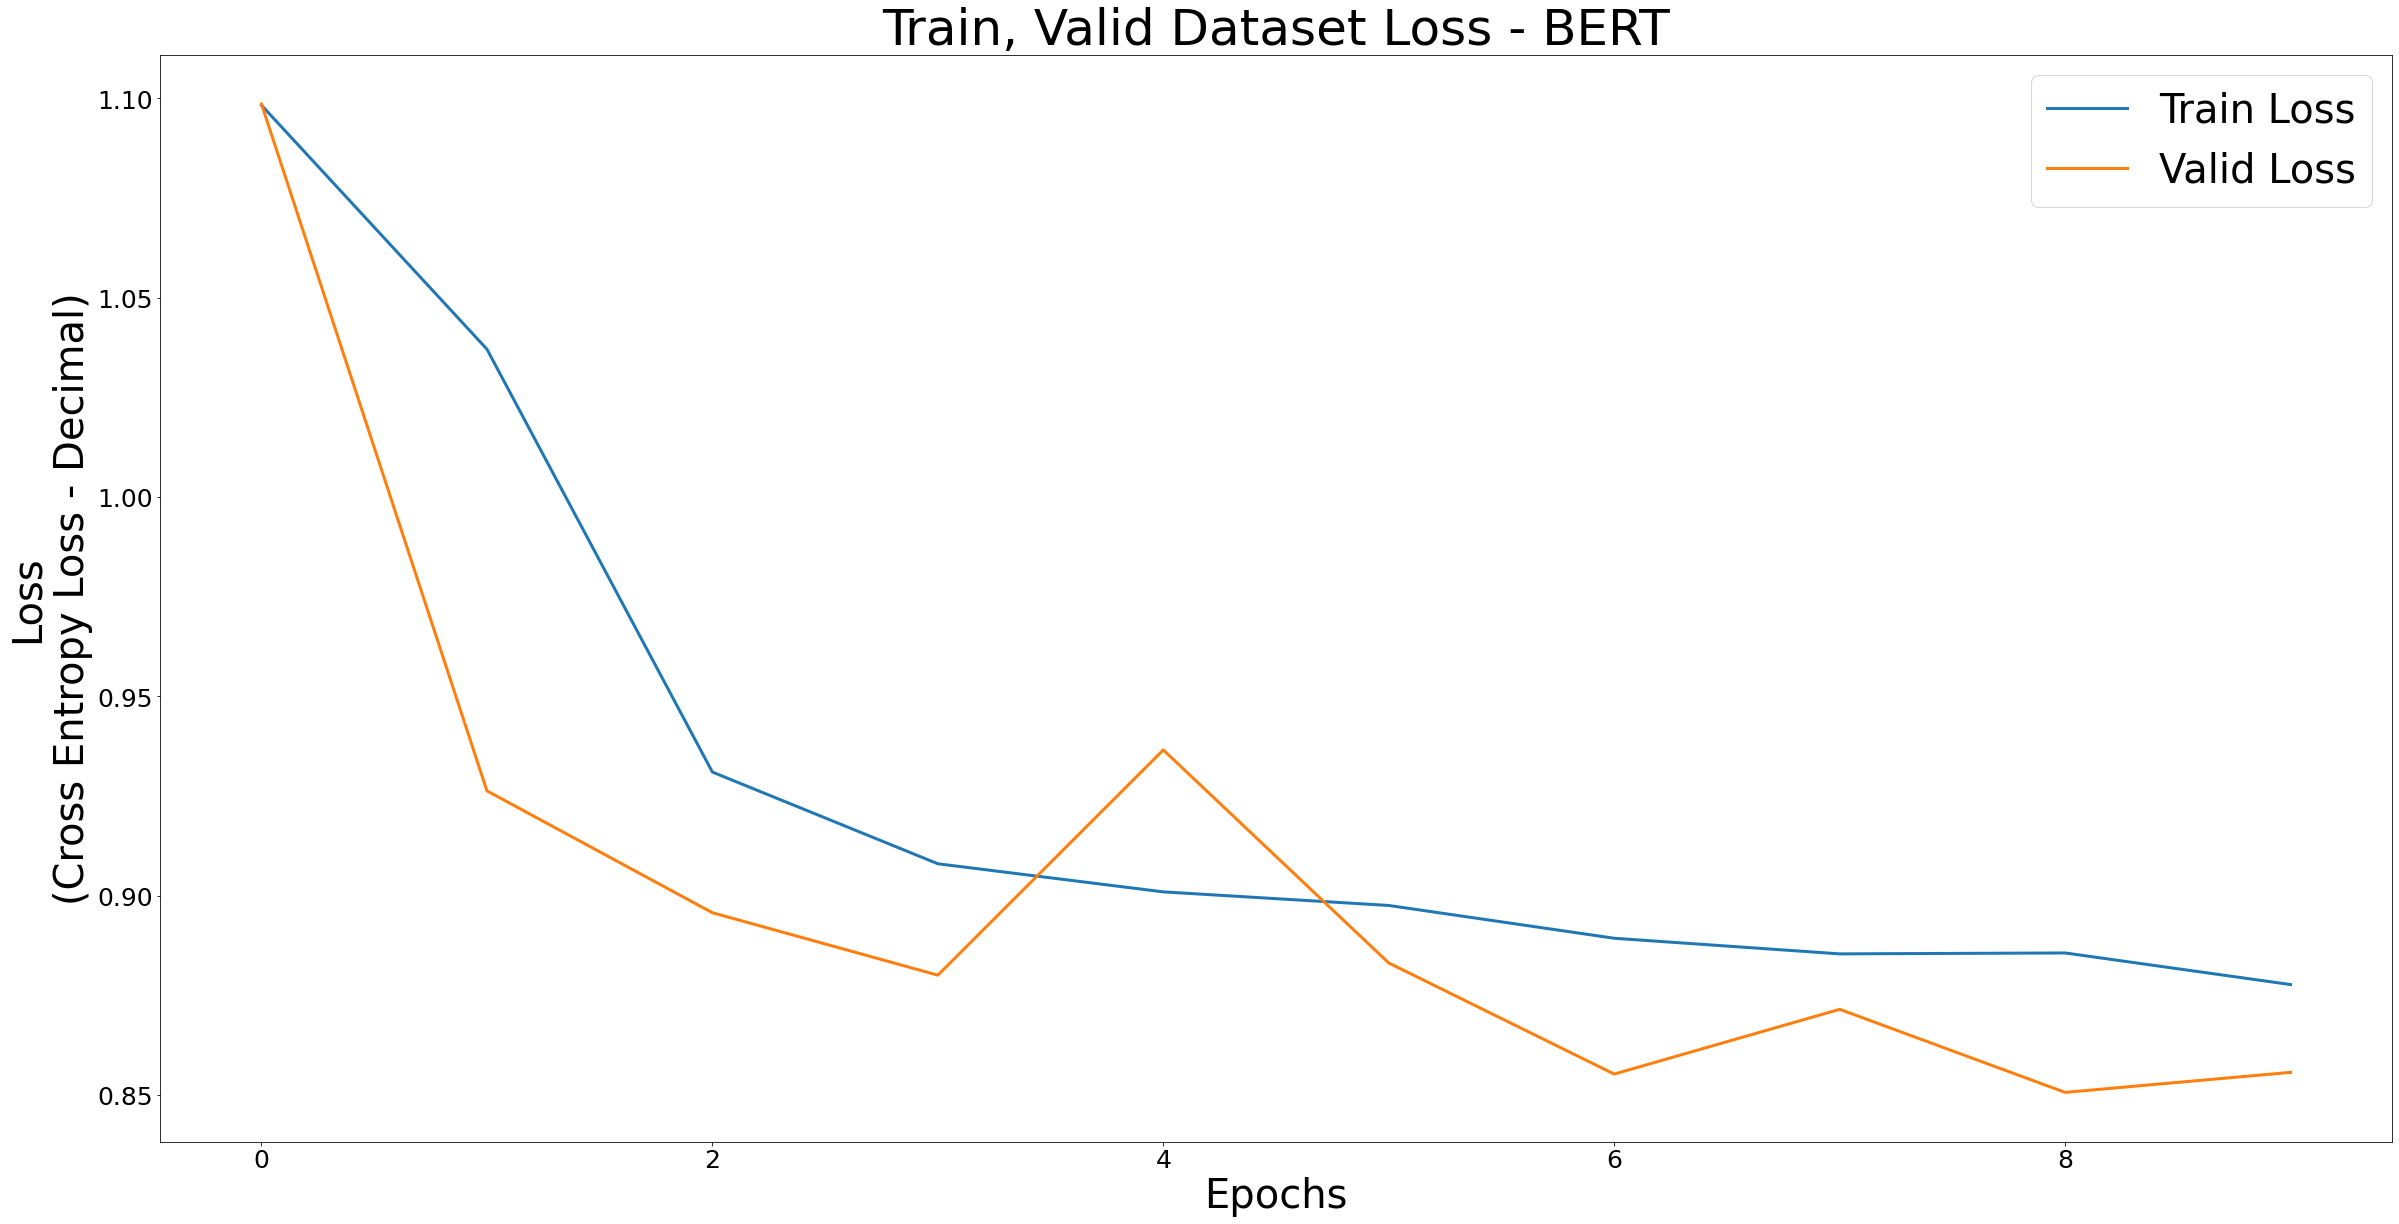

<Figure size 432x288 with 0 Axes>

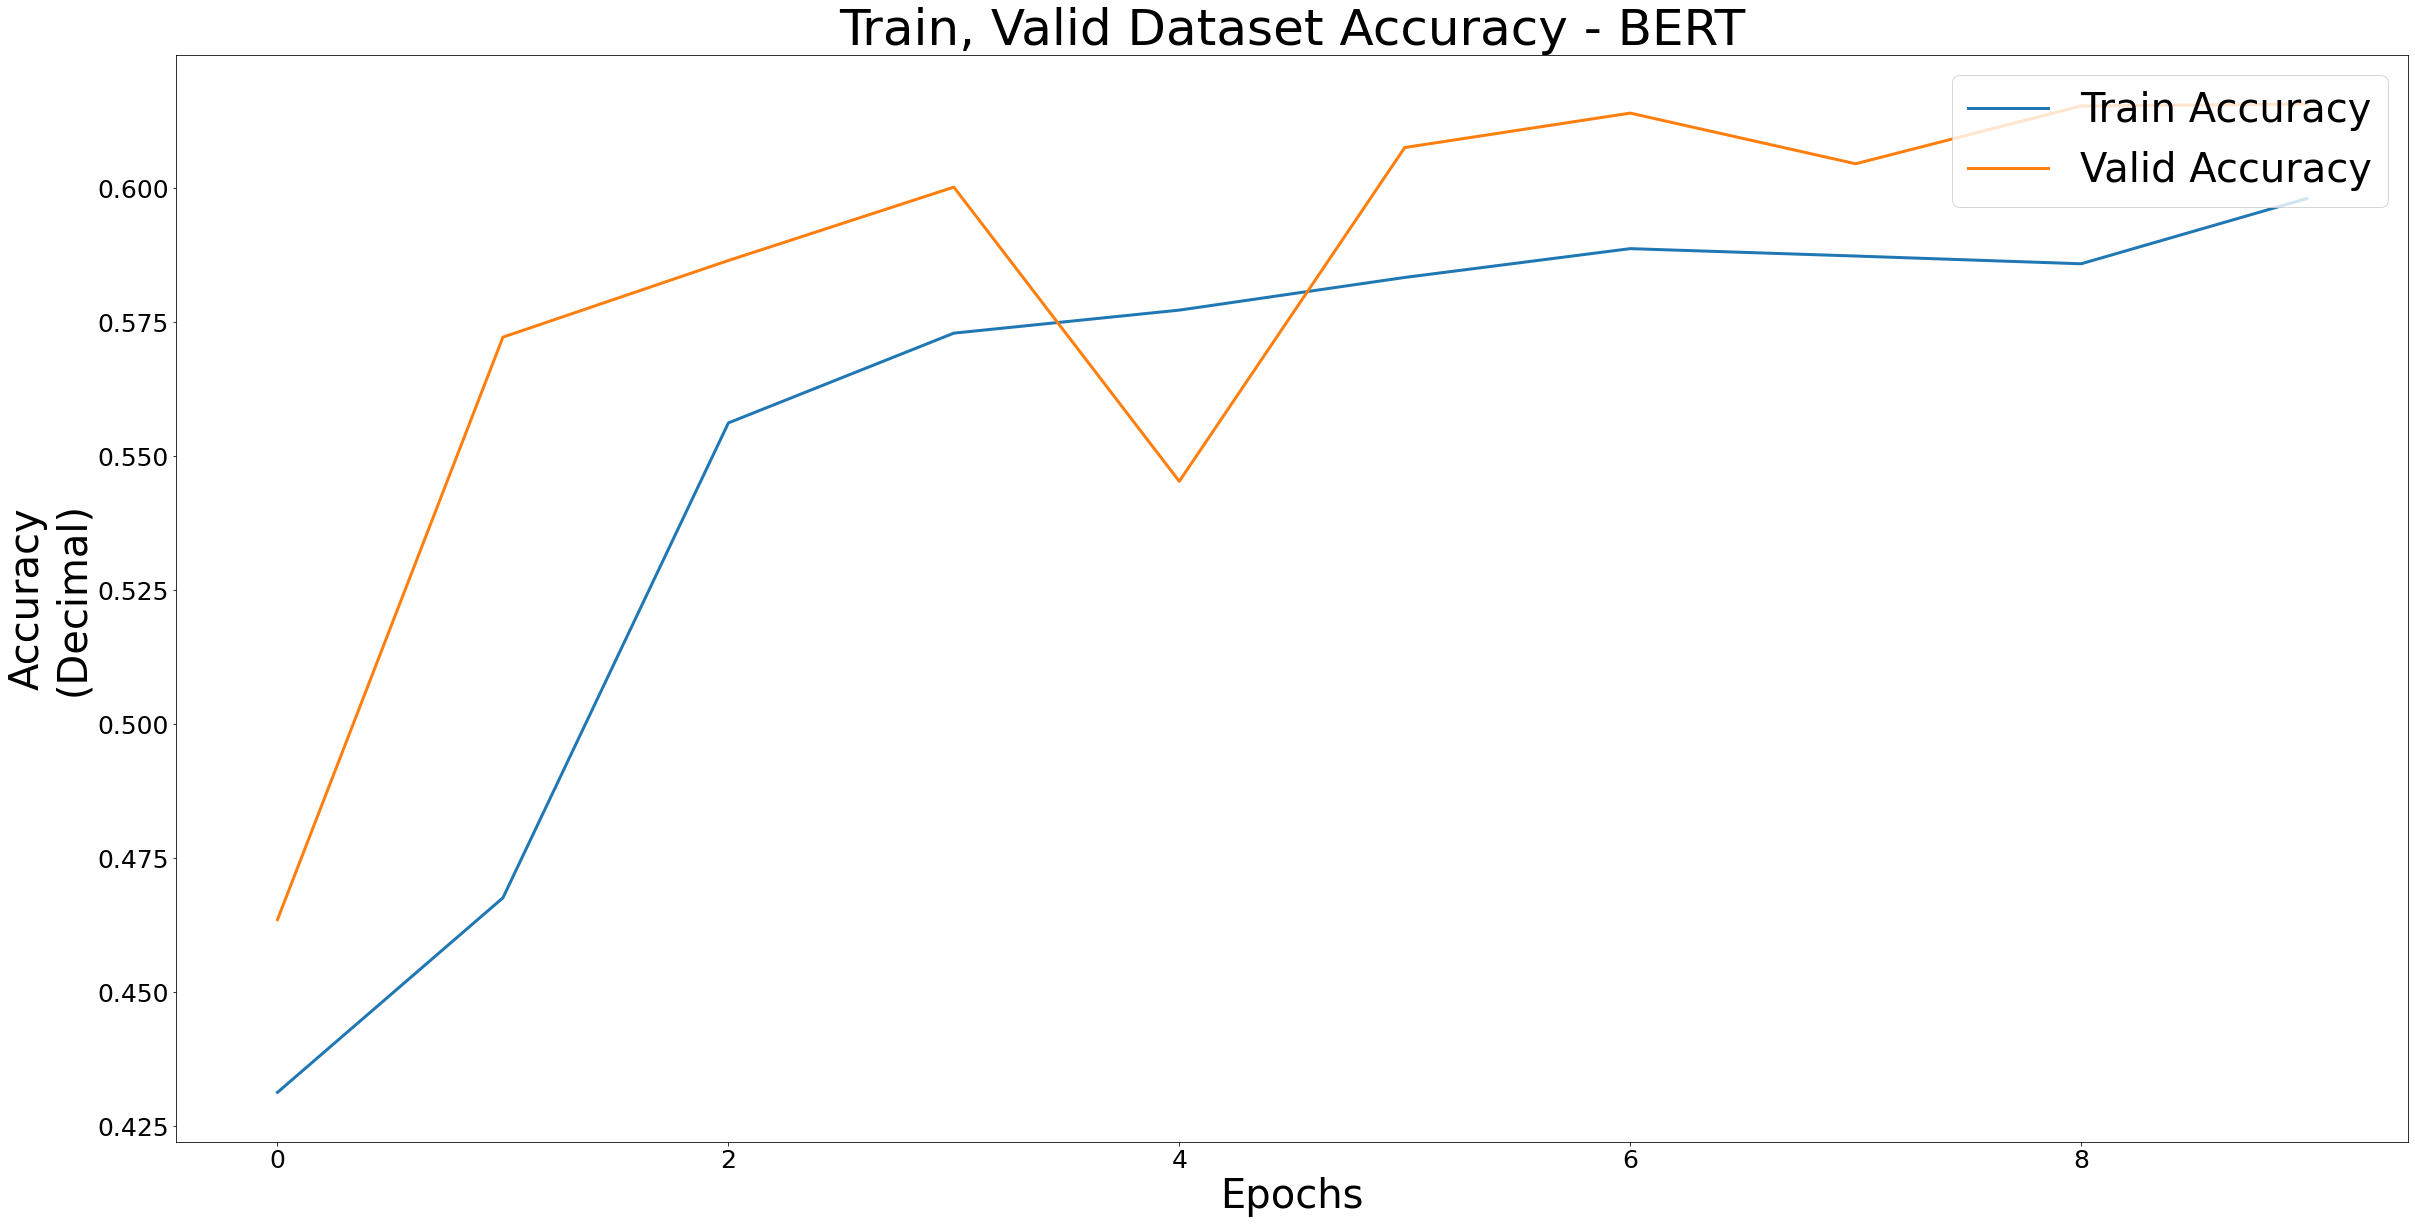

===== TESTING MODEL =====
Test Loss: 0.8563603733767983 - Test Acc: 61.08%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import json
import numpy as np
import pandas as pd
import numpy as np
from string import punctuation
import string
import torch.optim as optim
from torchtext import data
from string import punctuation
import nltk
import random
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = list(set(stopwords.words('english')))

import re

SEED = 2021
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True

from google.colab import drive
drive.mount('drive')

CONTENT = '/content/'
PATH_TO_CSV = '/content/drive/MyDrive/'

def clean_dataframe(df):
    #Dropping unnecessary columns.
    df = df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1)
    
    #Renaming 'OriginalTweet' to 'Tweet' to for the sake of brevity.
    df = df.rename({'OriginalTweet' : 'Tweet'}, axis=1)
    
    #Converting every character to lowercase to make sentiment analysis easier.
    df.Tweet = df.Tweet.apply(lambda x : x.lower())
    
    #Aggregating sentiments because there really isn't a difference between a negative tweet
    #and an extremely negative tweet.
    df.Sentiment = df.Sentiment.apply(lambda x : 'Negative' if x == 'Extremely Negative' else ('Positive' if x == 'Extremely Positive' else x))
    
    #Encoding the labels -- Originally had it such that (neg, neut, pos) == (-1, 0, 1) but 
    #kept receiving out of bounds error in training so I changed it to : (1, 0, 2)
    # Neg.  - 1 : Negative words have an affect
    # Neut. - 0 : Neutral words don't have that much of an affect
    # Pos.  - 2 : Positive words have an affect
    # Sentiment isn't affected by these labels, they just make more sense like this.
    df.Sentiment = df.Sentiment.apply(lambda x : 1 if x == 'Negative' else (0 if x == 'Neutral' else 2))
    
    #Remove any columns wherein there exists no tweet or no sentiment.
    df = df[df['Tweet'] != '']
    df = df.reset_index(drop=True)
    df = df[df['Sentiment'] != '']
    df = df.reset_index(drop=True)
    
    
    return df


def clean_tweet(tweet):
    to_remove = ['\r','\n',',',';',':','.', ''] #punctuation to be removed
    
    out = re.sub(r'http\S+', '', tweet) #removes links
    out = re.sub('[^a-zA-Z0-9]', '', out) #removes words not starting with a lower/upper case letter or number
    out = re.sub(r' +', ' ', out) #reduces spaces > 1 to 1
    out = re.sub(r'\n', ' ', out) # remove newline
    
    for token in to_remove:
        out = out.replace(token, '')
    
    return re.sub(' +', ' ', out.lower()) 


def filter_nonstopwords_nonpunctuation(words):
    # Filters out non-stop words
    return list(filter(lambda word : (word not in stop_words), words))


def process_dataframe(df):
    df.Tweet = df.Tweet.apply(lambda tweet : ' '.join((list(map(lambda word : clean_tweet(word), 
                               filter_nonstopwords_nonpunctuation(tweet.split()))))))
    
    #Some tweets may be removed therefore it's necessary to remove them.
    df = df[df['Tweet'] != '']
    df = df.reset_index(drop=True)
    
    return df
    

def create_valid_dataframe(train):
    #80:20 split on training and validation set. 
    train, valid = train[:int(len(train) * 0.80)], train[int(len(train) * 0.80):]
    #Since indexes will be different now, they must be reset.
    train = train.sample(frac = 1, random_state=SEED)
    train = train.reset_index(drop=True)
    valid = valid.sample(frac = 1, random_state=SEED)
    valid = valid.reset_index(drop=True)
    
    return train, valid


# Sometimes when this cell is run, a future warning appears. I'm not sure if this affects the results
# but if it occurs, just rereun the previous cells and it goes away.

train = pd.read_csv(PATH_TO_CSV + 'Corona_NLP_train.csv', encoding="latin1")
test  = pd.read_csv(PATH_TO_CSV + 'Corona_NLP_test.csv',  encoding="latin1")

train, test  = clean_dataframe(train), clean_dataframe(test)

# #Reducing size of data
# train, test = train[:10_000], test[:10_000]

train, valid = create_valid_dataframe(train)
train, valid, test = process_dataframe(train), process_dataframe(valid), process_dataframe(test)

train.to_csv('train.csv')
valid.to_csv('valid.csv')
test.to_csv('test.csv')

# BERT requires tokens used to denote the start and end of a sentence, padding tokens, and unknown tokens.
import transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


MAX_SEQ_LEN = 128
INIT_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.cls_token)
EOS_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.eos_token)
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup

max_input_length = 128

#Tokenises sentences and cuts those that are too long
def tokenize_and_cut(sentence):
    return tokenizer.tokenize(sentence)[:max_input_length-2]

#Field procesisng is similar to before except here each sentence gets an initialised token, and end of sequence token
#padded tokens to reach max length, and then an unk token for unknown words.
from torchtext.legacy import data
Tweet = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = lambda sentence : tokenizer.tokenize(sentence)[:max_input_length-2],
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = INIT_INDEX,
                  eos_token = EOS_INDEX,
                  pad_token = PAD_INDEX,
                  unk_token = UNK_INDEX)

Sentiment = data.LabelField(dtype=torch.float)

fields = [
          (None, None),
          ('Tweet', Tweet), 
          ('Sentiment', Sentiment)
         ]

train, valid, test = data.TabularDataset.splits(path=CONTENT, 
                                            format='csv', 
                                            train='train.csv', 
                                            validation='valid.csv', 
                                            test='test.csv',
                                            fields=fields, 
                                            skip_header=True)

Sentiment.build_vocab(train)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')


BATCH_SIZE = 32 #Batch is smaller because BERT is slow.
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, valid, test), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.Tweet),
    sort_within_batch=True,
    device = device)

import torch.nn as nn
from transformers import BertTokenizer, BertModel,BertForSequenceClassification
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import json

def calculate_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
  
    return acc

import matplotlib.pyplot as plt
def plot_losses(x, y, epochs, model_type):
    plt.figure(figsize=(40,20))
    plt.title(f"Train, Valid Dataset Loss - {model_type}", fontsize=50)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlabel("Epochs", fontsize=40)
    plt.ylabel("Loss\n(Cross Entropy Loss - Decimal)", fontsize=40)
    plt.plot([i for i in range(epochs)], x, label = 'Train Loss', linewidth=3)
    plt.plot([i for i in range(epochs)], y, label = 'Valid Loss', linewidth=3)
    plt.legend(loc='upper right', prop={'size': 40}) 
    plt.show()
    plt.savefig(model_type + '_Losses')
    
    
import matplotlib.pyplot as plt
def plot_accuracy(x, y, epochs, model_type):
    plt.figure(figsize=(40,20))
    plt.title(f"Train, Valid Dataset Accuracy - {model_type}", fontsize=50)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlabel("Epochs", fontsize=40)
    plt.ylabel("Accuracy\n(Decimal)", fontsize=40)
    plt.plot([i for i in range(epochs)], x, label = 'Train Accuracy', linewidth=3)
    plt.plot([i for i in range(epochs)], y, label = 'Valid Accuracy', linewidth=3)
    plt.legend(loc='upper right', prop={'size': 40}) 
    plt.show()
    #plt.savefig(model_type + '_Accuracy')
    
    
#Pretrained BERT model
bert = BertModel.from_pretrained('bert-base-uncased')

class BERT(nn.Module):
    def __init__(self, bert, hidden_dimension, output_dimension, layers):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dimension = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.RNN(embedding_dimension, hidden_dimension, num_layers = layers, bidirectional = True, batch_first = True)
        
        self.linear_layer = nn.Linear(hidden_dimension * 2, output_dimension)
        
    def calculate_loss_accuracy(self, predictions, sentiment, criterion):
        
        return criterion(predictions, (sentiment).long()), calculate_accuracy(predictions, sentiment)
        
    def forward(self, text):
        
        #Ensures no gradients are calculated
        #Returns embeddings for sequence and pooled output.
        #Pooled output isn't considered as it doesn't represent good semantic summary of input
        with torch.no_grad():
            embedded = self.bert(text)[0]
       
        _, hidden = self.rnn(embedded)
        
        #Concating the forward pass and backward pass of the bidirectional behaviour
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        
        output = self.linear_layer(hidden)
        
        
        return torch.nn.functional.relu(output)
    
    def train_model(self, iterator, optimizer, criterion):
    
        epoch_loss = 0
        epoch_acc = 0

        model.train()
        i = 0
        #Uncomment to see progression if it takes too long to finish an epoch
        for batch in iterator:
            #print(f'{i}/{len(iterator)}')
            i+=1

            optimizer.zero_grad()

            predictions = self.forward(batch.Tweet).squeeze(1)

            loss, acc = self.calculate_loss_accuracy(predictions, batch.Sentiment, criterion)
            
            loss.backward()

            optimizer.step()

            epoch_loss, epoch_acc = epoch_loss + loss.item(), epoch_acc + acc.item()

        return epoch_loss / len(iterator), epoch_acc / len(iterator)

    def evaluate_model(self, iterator, criterion):
    
        epoch_loss = 0
        epoch_acc = 0

        model.eval()
        i = 0
        with torch.no_grad():

            for batch in iterator:
                #print(f'{i}/{len(iterator)}')
                i+=1

                predictions = self.forward(batch.Tweet).squeeze(1)

                loss, acc = self.calculate_loss_accuracy(predictions, batch.Sentiment, criterion)

                epoch_loss, epoch_acc = epoch_loss + loss.item(), epoch_acc + acc.item()

        return epoch_loss / len(iterator), epoch_acc / len(iterator)
    
    def execute_model(self, train_iterator, valid_iterator, optimizer, criterion, EPOCHS_T0_TRAIN_TO, model_name):
        
        loss_ = float('inf')
        
        print("===== TRAINING MODEL =====")
        #Arrays that will hold loss and accuracy values for plotting
        train_losses = []
        train_accs = []
        valid_losses = []
        valid_accs = [] 
        for epoch in range(EPOCHS_T0_TRAIN_TO):
            train_loss, train_acc = self.train_model(train_iterator, optimizer, criterion)
            valid_loss, valid_acc = self.evaluate_model(valid_iterator, criterion)

            #If the validation loss is less than loss_, loss_ becomes validation loss
            # representing the current best loss in the model.
            if valid_loss < loss_:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), model_name)
            print(f'Epoch : {epoch}')
            print(f'Train Loss: {train_loss} - Train Acc: {train_acc*100:.2f}%')
            print(f'Valid Loss: {valid_loss} - Valid Acc: {valid_acc*100:.2f}%')
            
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            train_accs.append(train_acc)
            logs ={
                "model": model_name,
                "train_losses": train_losses,
                "train_accs": train_accs,
                "val_losses": valid_losses,
                "val_accs": valid_accs,
                "best_val_epoch": int(np.argmax(valid_accs)+1),
                "model": model_name,
                "lr": 1e-3,
                "l2": 1e-3,
                "hidden_dimension":64,
                "batch_size":32
            }
            with open(os.path.join(CONTENT,"{}_{}.json".format(logs['model'],  epoch)), 'w') as f:
                 json.dump(logs, f)
               
        plot_losses(train_losses, valid_losses, EPOCHS_T0_TRAIN_TO, "BERT")
        plot_accuracy(train_accs, valid_accs, EPOCHS_T0_TRAIN_TO, "BERT")

    
    def test_model(self, model, test_iterator, criterion, model_name):
        
        print("===== TESTING MODEL =====")
        
        model.load_state_dict(torch.load(model_name))

        test_loss, test_acc = self.evaluate_model(test_iterator, criterion)

        print(f'Test Loss: {test_loss} - Test Acc: {test_acc*100:.2f}%')

HIDDEN_DIM = 64
OUTPUT_DIM = len(Sentiment.vocab)
N_LAYERS = 2

model = BERT(bert, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS)

#if this isn't set, the amount of paramters would be extremely large.
for name, param in bert.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

optimizer = optim.Adam(model.parameters(), weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

model.execute_model(train_iterator, valid_iterator, optimizer, criterion, 10 ,"Best_BERT.pt")
model.test_model(model, test_iterator, criterion, "Best_BERT.pt")


In [15]:
from google.colab import files
files.download('BERT_Exp1.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
files.download('BERT_Exp2.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>